In [477]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [478]:
# helper function for printing tables
def printTable(header, data):
    """
    Prints table with columns of header and data.
    
    Parameters
    ----------
    header : []
        list of header labels
        ex. header = ["one","two","three"]
    data : [[],[],...,[]]
        list of lists, each inner list is a data line
        data line must index with header appropriately
        ex. data = [[1, 2, 3],[1, 2, 3]]
    """
    
    # print headers
    col_widths=[]
    for i,label in enumerate(header):
        col_widths.append(len(label))
        if i == 0 :
            print("| ",end="")
        print(str(label).center(len(label)), end=" | ")
    print()
    
    # print separating line
    for i,width in enumerate(col_widths):
        if i == 0 :
            print("| ",end="")
        print("".center(width,"-"), end=" | ")
    print()
    
    # print data
    for i,line in enumerate(data):
        for i,value in enumerate(line):
            if i == 0 :
                print("| ",end="")
            print(str(value).center(col_widths[i]), end=" | ")
        print()

In [479]:
# parse json file to features - phillip
data_file_name = '../data/data.json'
nPoints = 21
with open(data_file_name) as json_file:
    data = json.load(json_file)
    
    # matrix to store distance to keypoint 0, each image stored in row
    # column array to store labels

    distance_feature = np.ones((int(data["num_pics"]), nPoints-1))
    label_vector = np.ones((int(data["num_pics"]),1))
    
    # loop through json to constuct feature array
    for i in range(1, int(data["num_pics"])+1): # use num_pics+1 because range ends at integer before stop value
        label = data["pics"][str(i)]["label"] 
        points = np.array(data["pics"][str(i)]["keypoints"] )
        
        # label array
        label_vector[i-1] = label
        # feature matrix
        pointZero = points[0] # reference distance from point 0
        for j in range(1,nPoints): # calculate distances for points 1-20
            distance_feature[i-1][j-1] = math.sqrt(np.sum(np.square(points[j] - pointZero)))
        
#     print(distance_feature)
#     print(label_vector)

In [480]:
# dummy data
# layout: [thumb, pointer, middle, ring, pinky]
X = np.array([[1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1],
              [2, 1, 1, 1, 1],
              [1, 2, 1, 1, 1],
              [1, 1, 1, 1, 2],
              [1, 2, 2, 1, 1],
              [2, 1, 1, 1, 2],
              [1, 2, 1, 1, 2],
              [1, 2, 2, 2, 1],
              [2, 2, 1, 1, 2],
              [1, 2, 1, 2, 2],
              [1, 2, 2, 2, 2],
              [2, 2, 2, 2, 1],
              [2, 2, 2, 1, 2],
              [2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2],])

b = np.array([[0], 
              [0], 
              [0], 
              [1], 
              [1], 
              [1], 
              [2], 
              [2], 
              [2], 
              [3], 
              [3], 
              [3], 
              [4],
              [4], 
              [4], 
              [5], 
              [5], 
              [5]])

In [481]:
# least squares - bush



## Single Class SVM

In [482]:
# get data
X = distance_feature
b = label_vector

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
num_features = len(X[0])
w_k = np.zeros((num_features+1, 1))

r = 0 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
b_classes = np.zeros((len(b),len(classes)))
b_test_svm = np.zeros(b_classes.shape)
b_test_ls = np.zeros(b_classes.shape)
w_svm = np.zeros((len(w_k),len(classes)))
w_ls = np.zeros((len(w_k),len(classes)))

for c in classes:
    # form binary labels
    b_svm = np.where(b == c, 1, -1)
    b_classes[:,c] = b_svm.reshape(len(b_svm))
    
    # train svm
    num_steps = 1000
    counter = 0
    counter2 = 0
    for i in range(num_steps):
        # loop through training samples
        l_hinge = np.zeros(w_k.shape)
        for s in range(num_samples):
            # indicator function
            counter2 +=1
            if b_svm[s]*X_svm[s]@w_k < 1:
                counter +=1
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))
        w_k = w_k - tau*(l_hinge+2*r*w_k)
        
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    w_k_ls = np.linalg.inv(X_svm.T@X_svm)@X_svm.T@b_svm # least squares
    w_ls[:,c] = w_k_ls.reshape(len(w_k_ls))
#     print("Weights for class {}:".format(c))
#     print(w_k)

# test svm against known training data
header = ["class", "  svm  ", "least squares"]
data = []
for c in classes:
    b_hat_svm = X_svm@w_svm[:,c]
    b_hat_ls = X_svm@w_ls[:,c]
    b_test_svm[:,c] = b_hat_svm.reshape(len(b))
    b_test_ls[:,c] = b_hat_ls.reshape(len(b))

    # find percent incorrect
    num_incorrect_ls = np.sum(np.sign(b_test_ls[:,c]) != b_classes[:,c])
    percent_incorrect_ls = num_incorrect_ls/len(b)*100
    num_incorrect_svm = np.sum(np.sign(b_test_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm), "{:0.2f} %".format(percent_incorrect_ls)])

# print table
printTable(header,data)

| class |   svm   | least squares | 
| ----- | ------- | ------------- | 
|   0   |  0.00 % |     1.67 %    | 
|   1   |  5.00 % |     3.33 %    | 
|   2   | 16.67 % |    10.00 %    | 
|   3   | 16.67 % |     6.67 %    | 
|   4   | 16.67 % |    11.67 %    | 
|   5   | 16.67 % |     1.67 %    | 


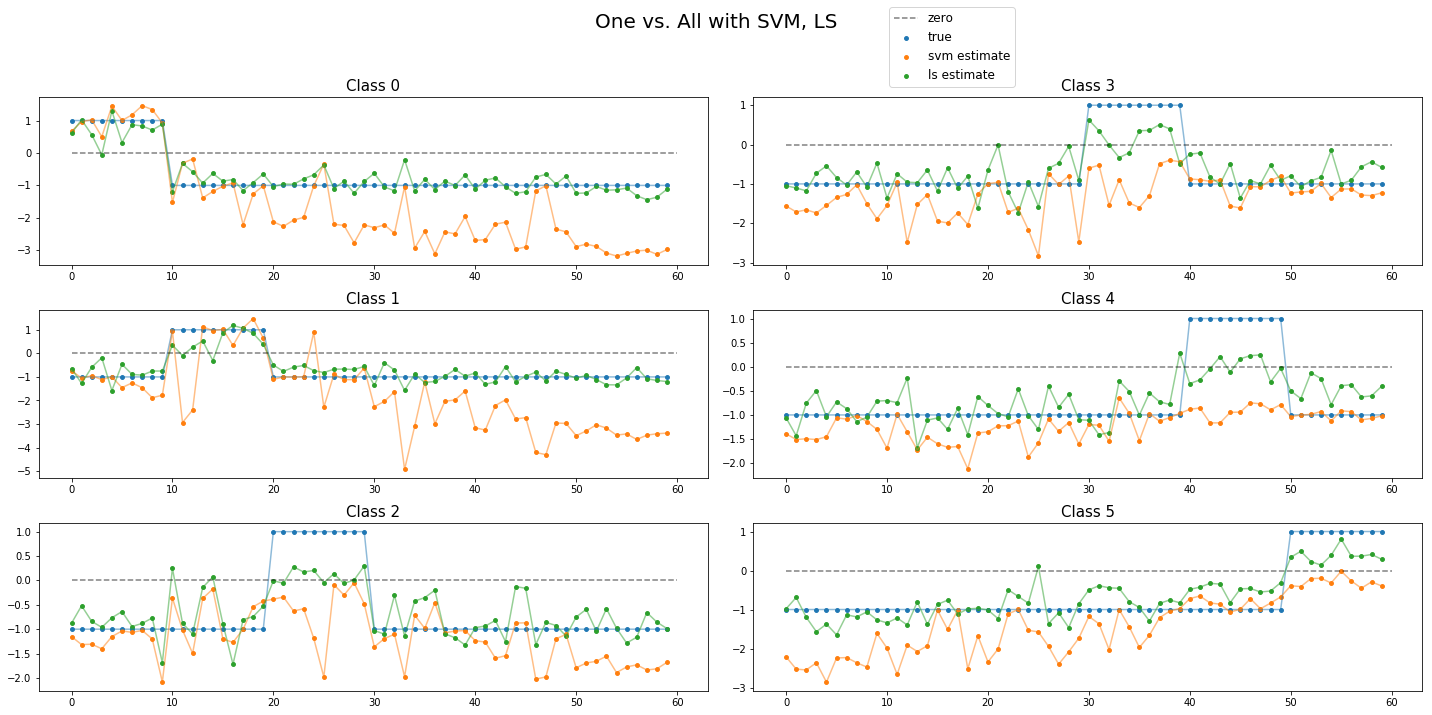

In [483]:
# plot
fig,ax = plt.subplots(3,2)
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]

for c in classes:
    if c < 3:
        count2 = 0
    else:
        count2 = 1
    ax[c%3][count2].set_title("Class {}".format(c),fontsize=15)
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_test_svm[:,c], label="svm estimate", color="C1", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_test_svm[:,c], alpha=0.5, color="C1")
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_test_ls[:,c], label="ls estimate", color="C2", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_test_ls[:,c], alpha=0.5, color="C2")
    ax[c%3][count2].plot([0,len(b_classes[:,c])], [0,0], alpha=0.5, linestyle="--", color="k", label="zero")

ax[0][1].legend(bbox_to_anchor=(0.4, 1.3), loc='right', ncol=1,fontsize=12) # legend
title = fig.suptitle("One vs. All with SVM, LS",fontsize=20) # title
fig.tight_layout() # prevent overlapping
plt.show()